In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-25 19:24:17.795603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:17.795854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:17.812301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:17.812540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:17.812712: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

#max_epochs = 200
#batch_size_setval = 10000
#learning_rate_setval = 1e-3
#patience_setval = 10

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 

max_epochs = 200
batch_size_setval = 1000
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 10**6





In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 4.98 s, sys: 34.3 ms, total: 5.02 s
Wall time: 5.02 s


In [9]:
theta0_G

array([ 0.42312153, -0.48831026,  0.20807631, ..., -0.14755846,
       -1.06888366,  0.59980955])

In [10]:
theta0_S

array([ -0.24021175,  -0.95825011, -10.        , ...,   0.07577508,
        -0.72277059,  -0.09567976])

In [11]:
theta0

array([[  0.42312153,  -0.24021175],
       [ -0.48831026,  -0.95825011],
       [  0.20807631, -10.        ],
       ...,
       [ -0.14755846,   0.07577508],
       [ -1.06888366,  -0.72277059],
       [  0.59980955,  -0.09567976]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(1000000,)

In [14]:
theta0.shape

(1000000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(1000000,)

/tmp/ipykernel_2608386/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


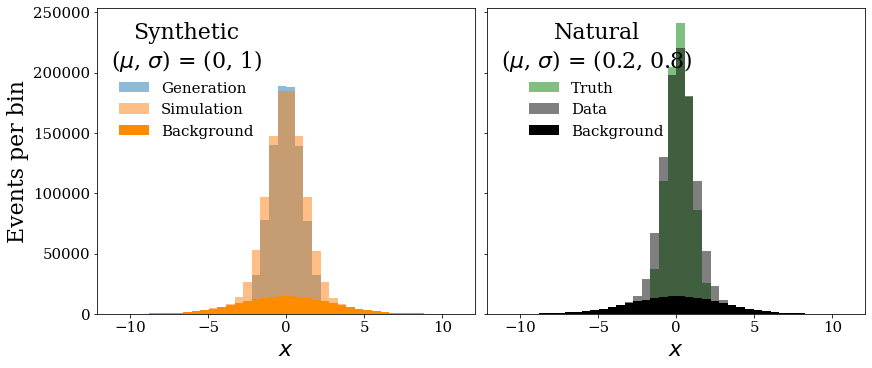

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-25 19:24:23.804482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:23.804688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:23.804862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:23.805022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:24:23.805185: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([ -0.24021175,  -0.95825011, -10.        , ...,   1.0185795 ,
        -0.21198584,   0.47181823])

In [21]:
xvals_1.shape

(2000000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(2000000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 113 ms, sys: 16.4 ms, total: 129 ms
Wall time: 129 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/100


2023-01-25 19:28:50.250292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-25 19:28:50.252508: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2c40060320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 19:28:50.252519: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-25 19:28:50.252523: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-25 19:28:50.255855: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-25 19:28:50.341999: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

1800/1800 [==============================] - 97s 53ms/step - loss: 0.5628 - accuracy: 0.4617 - val_loss: 0.5585 - val_accuracy: 0.4577
Epoch 2/100
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5576 - accuracy: 0.4585 - val_loss: 0.5569 - val_accuracy: 0.4577
Epoch 3/100
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5566 - accuracy: 0.4585 - val_loss: 0.5564 - val_accuracy: 0.4577
Epoch 4/100
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5563 - accuracy: 0.4585 - val_loss: 0.5562 - val_accuracy: 0.4577
Epoch 5/100
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5561 - accuracy: 0.4585 - val_loss: 0.5561 - val_accuracy: 0.4577
Epoch 6/100
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5560 - accuracy: 0.4585 - val_loss: 0.5561 - val_accuracy: 0.4577
Epoch 7/100
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5559 - accuracy: 0.4585 - val_loss: 0.5562 - val_accuracy: 0.

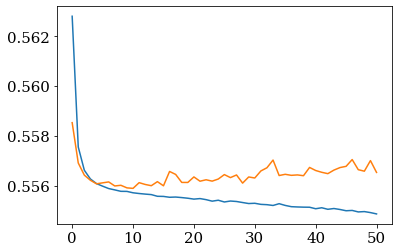

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

110/110 [==============================] - 0s 595us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_2608386/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


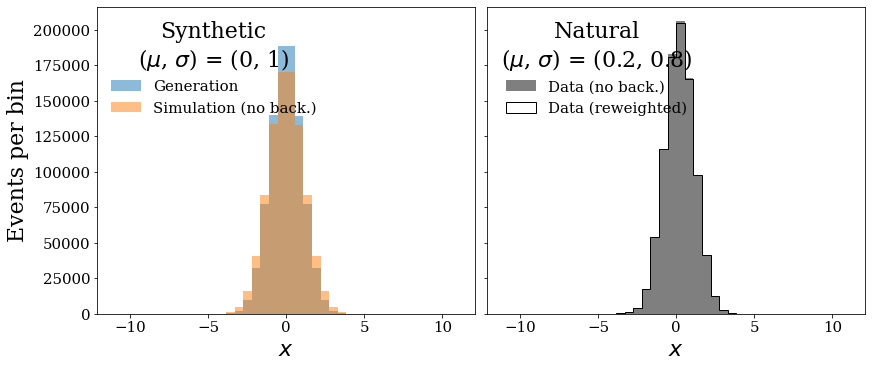

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

110/110 [==============================] - 0s 647us/step


In [32]:
model_output_bgsub

array([[0.35037744],
       [0.47533965],
       [0.45605677],
       ...,
       [0.24952903],
       [0.03852965],
       [0.13449916]], dtype=float32)

In [33]:
model_output_bgsub.shape

(1099608, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.35037744, 0.47533965, 0.45605677, ..., 0.24952903, 0.03852965,
       0.13449916], dtype=float32)

In [36]:
squeezed_model_output.shape

(1099608,)

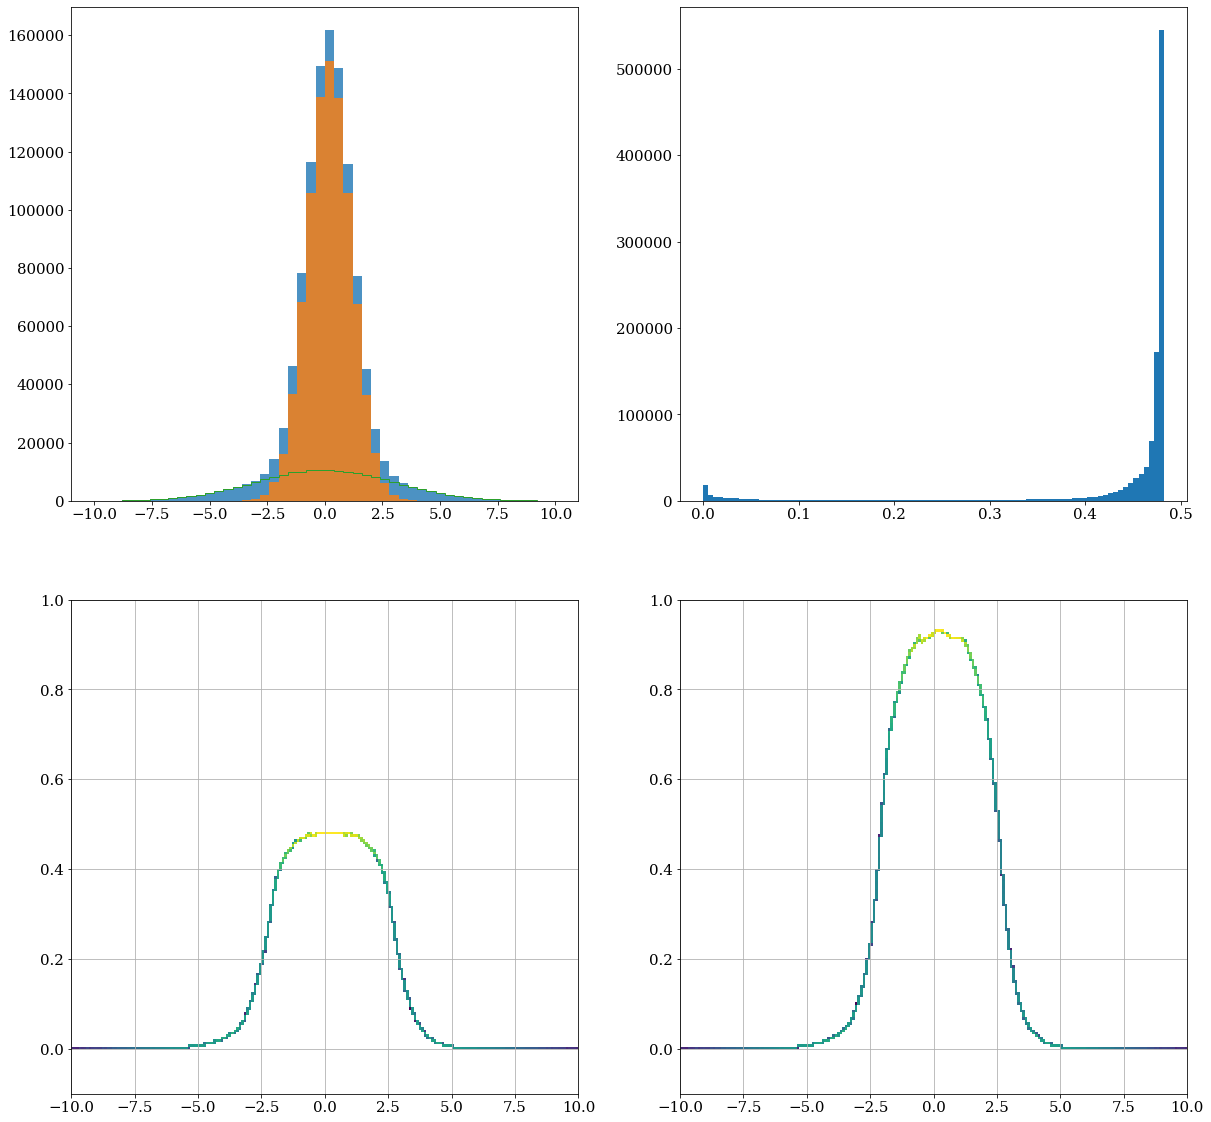

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

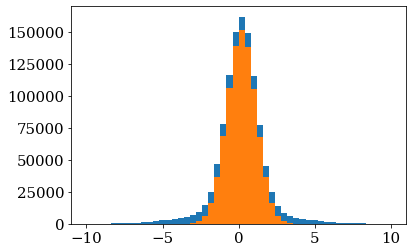

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([5.20000e+01, 7.90000e+01, 9.60000e+01, 1.59000e+02, 2.85000e+02,
        3.51000e+02, 5.02000e+02, 7.30000e+02, 9.56000e+02, 1.30800e+03,
        1.62000e+03, 2.11800e+03, 2.66500e+03, 3.29000e+03, 4.00700e+03,
        4.83700e+03, 5.60700e+03, 6.92700e+03, 9.31600e+03, 1.43610e+04,
        2.50630e+04, 4.63280e+04, 7.82640e+04, 1.16415e+05, 1.49520e+05,
        1.61752e+05, 1.48770e+05, 1.15620e+05, 7.72690e+04, 4.54540e+04,
        2.45540e+04, 1.36360e+04, 8.40500e+03, 6.14000e+03, 4.86100e+03,
        4.04200e+03, 3.31400e+03, 2.64100e+03, 2.06800e+03, 1.68000e+03,
        1.24900e+03, 9.49000e+02, 7.00000e+02, 4.60000e+02, 3.39000e+02,
        2.41000e+02, 1.58000e+02, 1.14000e+02, 8.20000e+01, 5.90000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2

In [40]:
hist_data_all[0]

array([5.20000e+01, 7.90000e+01, 9.60000e+01, 1.59000e+02, 2.85000e+02,
       3.51000e+02, 5.02000e+02, 7.30000e+02, 9.56000e+02, 1.30800e+03,
       1.62000e+03, 2.11800e+03, 2.66500e+03, 3.29000e+03, 4.00700e+03,
       4.83700e+03, 5.60700e+03, 6.92700e+03, 9.31600e+03, 1.43610e+04,
       2.50630e+04, 4.63280e+04, 7.82640e+04, 1.16415e+05, 1.49520e+05,
       1.61752e+05, 1.48770e+05, 1.15620e+05, 7.72690e+04, 4.54540e+04,
       2.45540e+04, 1.36360e+04, 8.40500e+03, 6.14000e+03, 4.86100e+03,
       4.04200e+03, 3.31400e+03, 2.64100e+03, 2.06800e+03, 1.68000e+03,
       1.24900e+03, 9.49000e+02, 7.00000e+02, 4.60000e+02, 3.39000e+02,
       2.41000e+02, 1.58000e+02, 1.14000e+02, 8.20000e+01, 5.90000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.03951368e-04, 2.49563264e-04, 4.75501344e-03,
       1.72998038e-02, 7.47798470e-02, 2.06955775e-01, 4.37852517e-01,
       6.46530743e-01, 7.89781558e-01, 8.72125115e-01, 9.08620023e-01,
       9.29206795e-01, 9.35333103e-01, 9.30557236e-01, 9.13821138e-01,
       8.77052893e-01, 8.03581643e-01, 6.68526513e-01, 4.60398944e-01,
       2.28911362e-01, 8.95765472e-02, 2.36576836e-02, 5.93765463e-03,
       9.05250453e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

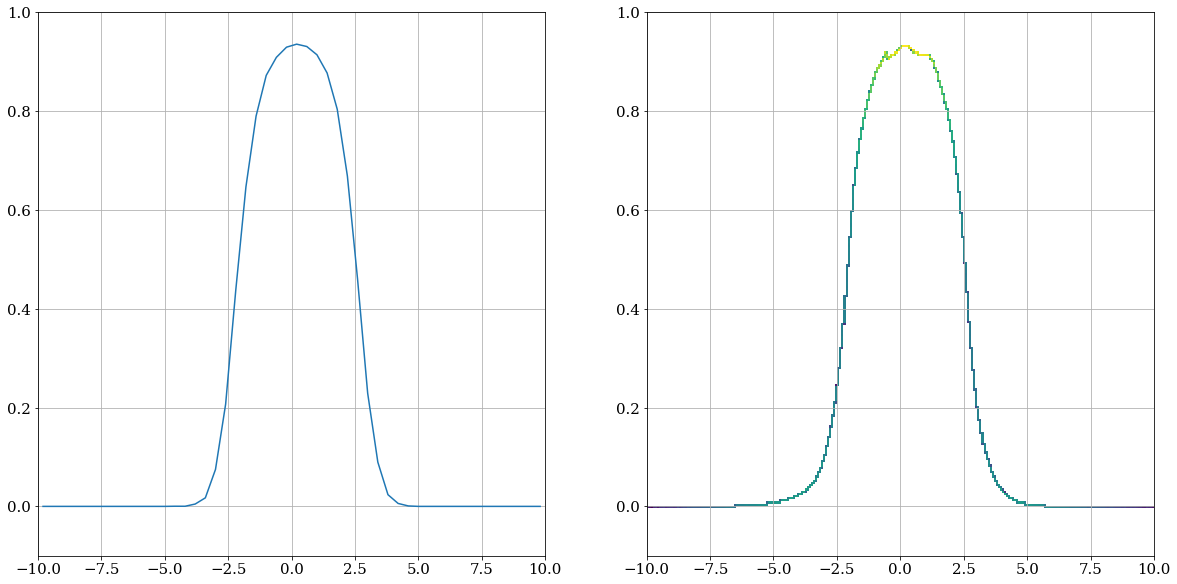

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 







    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    
    

    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    
    weights_push = reweight(theta0_G)
    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    




ITERATION: 1




 Iteration 1,  STEP 1, events that pass reco



Epoch 1/200
1500/1500 [==============================] - 84s 56ms/step - loss: 0.6147 - accuracy: 0.5280 - val_loss: 0.6143 - val_accuracy: 0.5274
Epoch 2/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6141 - accuracy: 0.5284 - val_loss: 0.6141 - val_accuracy: 0.5253
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6140 - accuracy: 0.5282 - val_loss: 0.6141 - val_accuracy: 0.5285
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6139 - accuracy: 0.5282 - val_loss: 0.6140 - val_accuracy: 0.5274
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6139 - accuracy: 0.5285 - val_loss: 0.6140 - val_accuracy: 0.5261
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6139 - accuracy: 0.5279 - val_loss: 0.6140 - val_accuracy: 0.5265
Epoch 7/200
1500/1500 [==============================] - 4s 

Epoch 57/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6137 - accuracy: 0.5437 - val_loss: 0.6139 - val_accuracy: 0.5420
Epoch 58/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5437 - val_loss: 0.6139 - val_accuracy: 0.5408
Epoch 59/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5436 - val_loss: 0.6138 - val_accuracy: 0.5420
Epoch 60/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5436 - val_loss: 0.6139 - val_accuracy: 0.5396
Epoch 61/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5434 - val_loss: 0.6138 - val_accuracy: 0.5438
Epoch 62/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5436 - val_loss: 0.6138 - val_accuracy: 0.5439
Epoch 63/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5437 - val_loss: 0.6138 -

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5437 - val_loss: 0.6139 - val_accuracy: 0.5408
Epoch 114/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5438 - val_loss: 0.6138 - val_accuracy: 0.5414
Epoch 115/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6137 - accuracy: 0.5434 - val_loss: 0.6138 - val_accuracy: 0.5434
Epoch 115: early stopping
100/100 [==============================] - 0s 590us/step



 Iteration 1,  STEP 1, events that do NOT pass reco



Epoch 1/200
1350/1350 [==============================] - 77s 56ms/step - loss: 0.6878 - accuracy: 0.5003 - val_loss: 0.6864 - val_accuracy: 0.5001
Epoch 2/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6862 - accuracy: 0.4997 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 3/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6862 - accuracy: 0.4998 - val_loss: 0.6863 - val_accuracy: 0.

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.4999 - val_loss: 0.6863 - val_accuracy: 0.5005
Epoch 53/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.4997 - val_loss: 0.6862 - val_accuracy: 0.5006
Epoch 54/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.4997 - val_loss: 0.6862 - val_accuracy: 0.5006
Epoch 55/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.5001 - val_loss: 0.6862 - val_accuracy: 0.5001
Epoch 56/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.4998 - val_loss: 0.6863 - val_accuracy: 0.5006
Epoch 57/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.4998 - val_loss: 0.6863 - val_accuracy: 0.5001
Epoch 58/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6861 - accuracy: 0.4999 - val_loss: 0.6863 - val_accuracy

1500/1500 [==============================] - 4s 2ms/step - loss: 0.6860 - accuracy: 0.5004 - val_loss: 0.6862 - val_accuracy: 0.4979
Epoch 7/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6860 - accuracy: 0.5006 - val_loss: 0.6862 - val_accuracy: 0.4980
Epoch 8/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6860 - accuracy: 0.5006 - val_loss: 0.6862 - val_accuracy: 0.4981
Epoch 9/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6860 - accuracy: 0.5005 - val_loss: 0.6862 - val_accuracy: 0.4979
Epoch 10/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6860 - accuracy: 0.5008 - val_loss: 0.6862 - val_accuracy: 0.4982
Epoch 11/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6860 - accuracy: 0.5006 - val_loss: 0.6862 - val_accuracy: 0.4982
Epoch 12/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6860 - accuracy: 0.5006 - val_loss: 0.6862 - val_accuracy: 0

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.4999 - val_loss: 0.6868 - val_accuracy: 0.4998
Epoch 20/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.5002 - val_loss: 0.6868 - val_accuracy: 0.5001
Epoch 21/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.5001 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 22/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.5001 - val_loss: 0.6868 - val_accuracy: 0.5001
Epoch 23/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.5000 - val_loss: 0.6868 - val_accuracy: 0.4999
Epoch 24/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.5002 - val_loss: 0.6868 - val_accuracy: 0.4999
Epoch 25/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6868 - accuracy: 0.5001 - val_loss: 0.6868 - val_accuracy

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5443 - val_loss: 0.6204 - val_accuracy: 0.5489
Epoch 14/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5446 - val_loss: 0.6204 - val_accuracy: 0.5438
Epoch 15/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5445 - val_loss: 0.6204 - val_accuracy: 0.5474
Epoch 16/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5450 - val_loss: 0.6204 - val_accuracy: 0.5425
Epoch 17/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5441 - val_loss: 0.6204 - val_accuracy: 0.5460
Epoch 18/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5448 - val_loss: 0.6204 - val_accuracy: 0.5455
Epoch 19/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5446 - val_loss: 0.6204 - val_accuracy

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5443 - val_loss: 0.6204 - val_accuracy: 0.5425
Epoch 70/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5443 - val_loss: 0.6204 - val_accuracy: 0.5459
Epoch 71/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5442 - val_loss: 0.6204 - val_accuracy: 0.5456
Epoch 72/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5449 - val_loss: 0.6204 - val_accuracy: 0.5452
Epoch 73/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6204 - accuracy: 0.5442 - val_loss: 0.6204 - val_accuracy: 0.5445
Epoch 73: early stopping
100/100 [==============================] - 0s 550us/step



 Iteration 2,  STEP 1, events that do NOT pass reco



Epoch 1/200
1350/1350 [==============================] - 75s 55ms/step - loss: 0.6864 - accuracy: 0.4998 - val_loss: 0.6837 - val_accuracy: 0.5

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.4997 - val_loss: 0.6837 - val_accuracy: 0.5004
Epoch 51/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.4999 - val_loss: 0.6837 - val_accuracy: 0.5004
Epoch 52/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.4998 - val_loss: 0.6837 - val_accuracy: 0.5003
Epoch 53/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.4999 - val_loss: 0.6837 - val_accuracy: 0.5003
Epoch 54/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.4999 - val_loss: 0.6837 - val_accuracy: 0.5003
Epoch 55/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.4996 - val_loss: 0.6837 - val_accuracy: 0.5005
Epoch 56/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6837 - accuracy: 0.5000 - val_loss: 0.6837 - val_accuracy

1500/1500 [==============================] - 4s 2ms/step - loss: 0.6836 - accuracy: 0.5000 - val_loss: 0.6833 - val_accuracy: 0.5007
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6836 - accuracy: 0.4996 - val_loss: 0.6833 - val_accuracy: 0.5006
Epoch 5/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6836 - accuracy: 0.4996 - val_loss: 0.6833 - val_accuracy: 0.5011
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6836 - accuracy: 0.4994 - val_loss: 0.6833 - val_accuracy: 0.5007
Epoch 7/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6836 - accuracy: 0.4998 - val_loss: 0.6833 - val_accuracy: 0.5007
Epoch 8/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6836 - accuracy: 0.4998 - val_loss: 0.6833 - val_accuracy: 0.5007
Epoch 9/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6836 - accuracy: 0.4997 - val_loss: 0.6833 - val_accuracy: 0.50

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5002 - val_loss: 0.6880 - val_accuracy: 0.4990
Epoch 8/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5001 - val_loss: 0.6880 - val_accuracy: 0.4989
Epoch 9/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5003 - val_loss: 0.6880 - val_accuracy: 0.4990
Epoch 10/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5003 - val_loss: 0.6880 - val_accuracy: 0.4990
Epoch 11/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5003 - val_loss: 0.6880 - val_accuracy: 0.4990
Epoch 12/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5004 - val_loss: 0.6880 - val_accuracy: 0.4989
Epoch 13/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6876 - accuracy: 0.5003 - val_loss: 0.6881 - val_accuracy: 

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5347 - val_loss: 0.6253 - val_accuracy: 0.5342
Epoch 21/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5365 - val_loss: 0.6253 - val_accuracy: 0.5231
Epoch 22/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5342 - val_loss: 0.6253 - val_accuracy: 0.5415
Epoch 23/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5361 - val_loss: 0.6253 - val_accuracy: 0.5376
Epoch 24/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5358 - val_loss: 0.6253 - val_accuracy: 0.5096
Epoch 25/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5328 - val_loss: 0.6253 - val_accuracy: 0.5311
Epoch 26/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5362 - val_loss: 0.6253 - val_accuracy

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5352 - val_loss: 0.6253 - val_accuracy: 0.5228
Epoch 77/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5350 - val_loss: 0.6253 - val_accuracy: 0.5393
Epoch 78/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5355 - val_loss: 0.6253 - val_accuracy: 0.5323
Epoch 79/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5351 - val_loss: 0.6253 - val_accuracy: 0.5370
Epoch 80/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6254 - accuracy: 0.5344 - val_loss: 0.6253 - val_accuracy: 0.5403
Epoch 80: early stopping
100/100 [==============================] - 0s 587us/step



 Iteration 3,  STEP 1, events that do NOT pass reco



Epoch 1/200
1350/1350 [==============================] - 72s 53ms/step - loss: 0.6822 - accuracy: 0.4999 - val_loss: 0.6807 - val_accuracy: 0.4

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.4999 - val_loss: 0.6806 - val_accuracy: 0.4998
Epoch 51/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.5001 - val_loss: 0.6806 - val_accuracy: 0.4997
Epoch 52/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.4999 - val_loss: 0.6806 - val_accuracy: 0.4996
Epoch 53/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.5001 - val_loss: 0.6806 - val_accuracy: 0.4997
Epoch 54/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.5001 - val_loss: 0.6806 - val_accuracy: 0.4997
Epoch 55/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.5001 - val_loss: 0.6806 - val_accuracy: 0.4998
Epoch 56/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6808 - accuracy: 0.5003 - val_loss: 0.6806 - val_accuracy

1500/1500 [==============================] - 4s 2ms/step - loss: 0.6807 - accuracy: 0.5002 - val_loss: 0.6805 - val_accuracy: 0.4991
Epoch 41/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6807 - accuracy: 0.5002 - val_loss: 0.6805 - val_accuracy: 0.4994
Epoch 42/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6807 - accuracy: 0.5001 - val_loss: 0.6805 - val_accuracy: 0.4992
Epoch 43/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6807 - accuracy: 0.5000 - val_loss: 0.6805 - val_accuracy: 0.4992
Epoch 43: early stopping



 Iteration 3,  STEP 2, events that do NOT pass reco



100/100 [==============================] - 0s 592us/step
Epoch 1/200
1350/1350 [==============================] - 77s 57ms/step - loss: 0.6861 - accuracy: 0.5001 - val_loss: 0.6859 - val_accuracy: 0.4993
Epoch 2/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6860 - accuracy: 0.5002 - val_loss: 0.6859 - val_accuracy: 0.49

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5279 - val_loss: 0.6248 - val_accuracy: 0.5265
Epoch 9/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5256 - val_loss: 0.6248 - val_accuracy: 0.5246
Epoch 10/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5240 - val_loss: 0.6249 - val_accuracy: 0.4763
Epoch 11/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5229 - val_loss: 0.6248 - val_accuracy: 0.5248
Epoch 12/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5282 - val_loss: 0.6249 - val_accuracy: 0.5097
Epoch 13/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5239 - val_loss: 0.6249 - val_accuracy: 0.5429
Epoch 14/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5259 - val_loss: 0.6249 - val_accuracy:

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5257 - val_loss: 0.6248 - val_accuracy: 0.5271
Epoch 65/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5254 - val_loss: 0.6248 - val_accuracy: 0.5191
Epoch 66/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5248 - val_loss: 0.6248 - val_accuracy: 0.5225
Epoch 67/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5267 - val_loss: 0.6248 - val_accuracy: 0.4987
Epoch 68/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5224 - val_loss: 0.6249 - val_accuracy: 0.5397
Epoch 69/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5239 - val_loss: 0.6249 - val_accuracy: 0.5412
Epoch 70/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6250 - accuracy: 0.5266 - val_loss: 0.6248 - val_accuracy

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5001 - val_loss: 0.6778 - val_accuracy: 0.4991
Epoch 22/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6778 - val_accuracy: 0.4991
Epoch 23/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5001 - val_loss: 0.6777 - val_accuracy: 0.4999
Epoch 24/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6777 - val_accuracy: 0.4991
Epoch 25/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6777 - val_accuracy: 0.4991
Epoch 26/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5003 - val_loss: 0.6777 - val_accuracy: 0.4998
Epoch 27/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5003 - val_loss: 0.6777 - val_accuracy

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5003 - val_loss: 0.6777 - val_accuracy: 0.4990
Epoch 78/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5003 - val_loss: 0.6777 - val_accuracy: 0.4991
Epoch 79/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5004 - val_loss: 0.6777 - val_accuracy: 0.4997
Epoch 80/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6778 - val_accuracy: 0.4991
Epoch 81/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5001 - val_loss: 0.6777 - val_accuracy: 0.4990
Epoch 82/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6778 - val_accuracy: 0.4992
Epoch 83/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6777 - val_accuracy

Epoch 133/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5001 - val_loss: 0.6777 - val_accuracy: 0.4991
Epoch 134/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5003 - val_loss: 0.6777 - val_accuracy: 0.4991
Epoch 135/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6777 - val_accuracy: 0.4999
Epoch 136/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5004 - val_loss: 0.6777 - val_accuracy: 0.4990
Epoch 137/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6777 - val_accuracy: 0.4991
Epoch 138/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0.6777 - val_accuracy: 0.4990
Epoch 139/200
1350/1350 [==============================] - 3s 2ms/step - loss: 0.6778 - accuracy: 0.5002 - val_loss: 0

Epoch 6/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6778 - accuracy: 0.4999 - val_loss: 0.6778 - val_accuracy: 0.5005
Epoch 7/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6778 - accuracy: 0.4999 - val_loss: 0.6778 - val_accuracy: 0.5003
Epoch 8/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6778 - accuracy: 0.4997 - val_loss: 0.6779 - val_accuracy: 0.5006
Epoch 9/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6778 - accuracy: 0.4998 - val_loss: 0.6779 - val_accuracy: 0.5004
Epoch 10/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6778 - accuracy: 0.5000 - val_loss: 0.6779 - val_accuracy: 0.5002
Epoch 11/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6778 - accuracy: 0.4998 - val_loss: 0.6778 - val_accuracy: 0.5003
Epoch 12/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6778 - accuracy: 0.4998 - val_loss: 0.6778 - val

1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.4999 - val_loss: 0.6834 - val_accuracy: 0.5000
Epoch 18/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.5000 - val_loss: 0.6834 - val_accuracy: 0.5000
Epoch 19/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.5000 - val_loss: 0.6834 - val_accuracy: 0.5000
Epoch 20/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.4996 - val_loss: 0.6834 - val_accuracy: 0.4999
Epoch 21/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.4999 - val_loss: 0.6834 - val_accuracy: 0.5001
Epoch 22/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.4998 - val_loss: 0.6834 - val_accuracy: 0.4999
Epoch 23/200
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6830 - accuracy: 0.4998 - val_loss: 0.6834 - val_accuracy

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

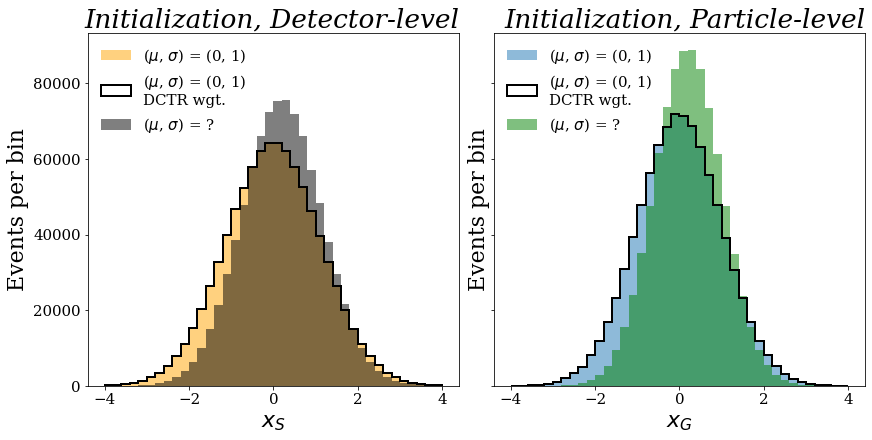

<Figure size 864x360 with 0 Axes>

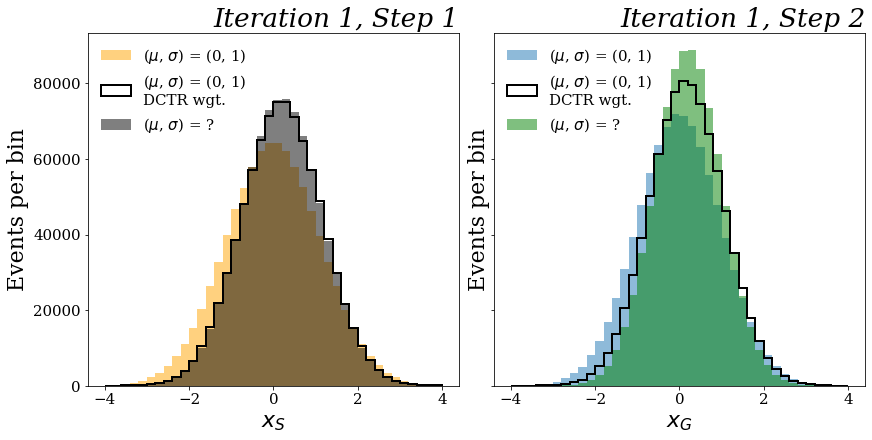

<Figure size 864x360 with 0 Axes>

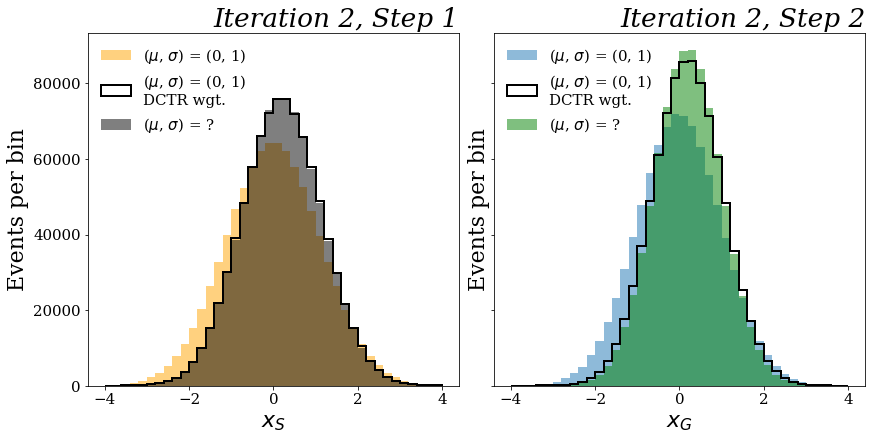

<Figure size 864x360 with 0 Axes>

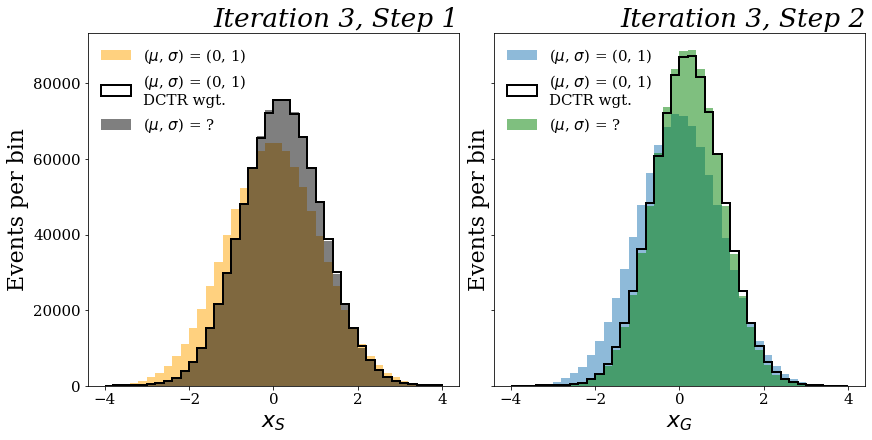

<Figure size 864x360 with 0 Axes>

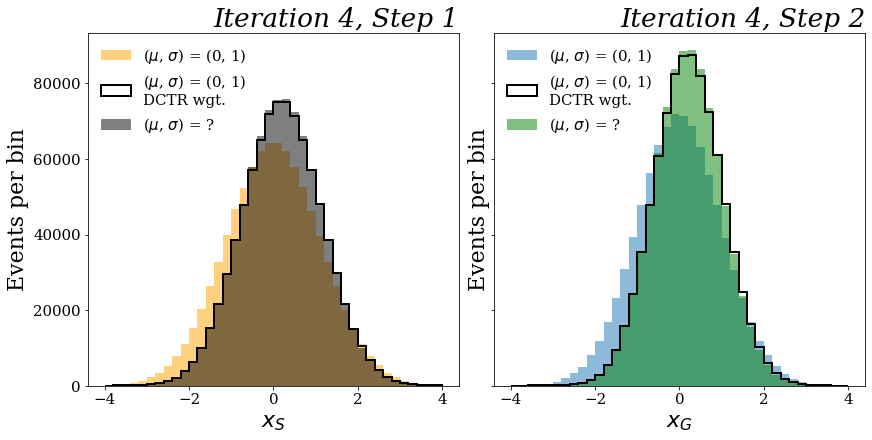

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.06943834, 0.80386013, 1.15246308, ..., 1.16445851,
         0.90628433, 1.11393821],
        [1.17301893, 0.96417356, 1.14818645, ..., 1.0698818 ,
         0.75392026, 1.19071102]],

       [[1.23008978, 0.91160423, 1.21833932, ..., 1.15404177,
         0.74555326, 1.26415288],
        [1.26244116, 0.95862669, 1.23061383, ..., 1.11536658,
         0.68251759, 1.27845025]],

       [[1.27588415, 0.9333747 , 1.24685371, ..., 1.14074051,
         0.67906082, 1.30025423],
        [1.28577912, 0.9601658 , 1.24797118, ..., 1.12513769,
         0.65513581, 1.29647672]],

       [[1.2847482 , 0.9456768 , 1.24906206, ..., 1.13378251,
         0.65291125, 1.30344534],
        [1.2941215 , 0.95703602, 1.25294638, ..., 1.13039196,
         0.63337541, 1.29989624]]])

In [53]:
weights.shape

(4, 2, 1000000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([ 1.88936723, -1.30553815,  1.71287784, ..., -2.30157879,
       -3.56318341, -2.73666326])

In [57]:
x_data_and_MCback.shape

(2399216,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(2399216,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(2399216,)

In [62]:
w_data

array([0.5393554 , 0.905995  , 0.8384272 , ..., 0.33249658, 0.04007368,
       0.1554004 ], dtype=float32)

In [63]:
w_data.shape

(1099608,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([ 2.48754456, -0.43923863, -1.19532051, ..., -2.30157879,
       -3.56318341, -2.73666326])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(1099608,)

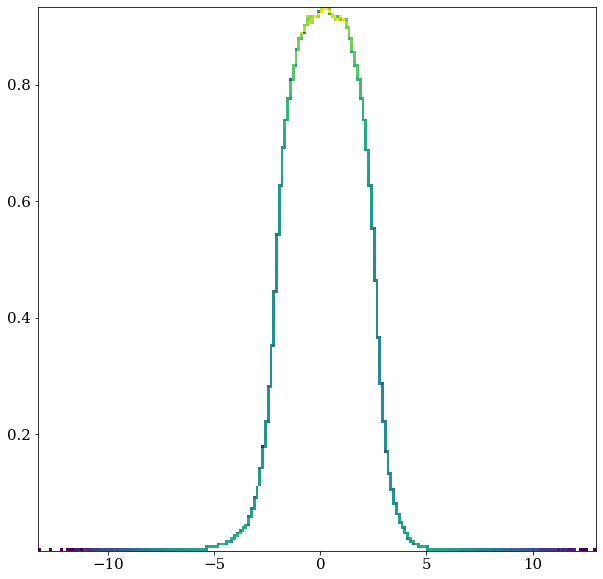

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

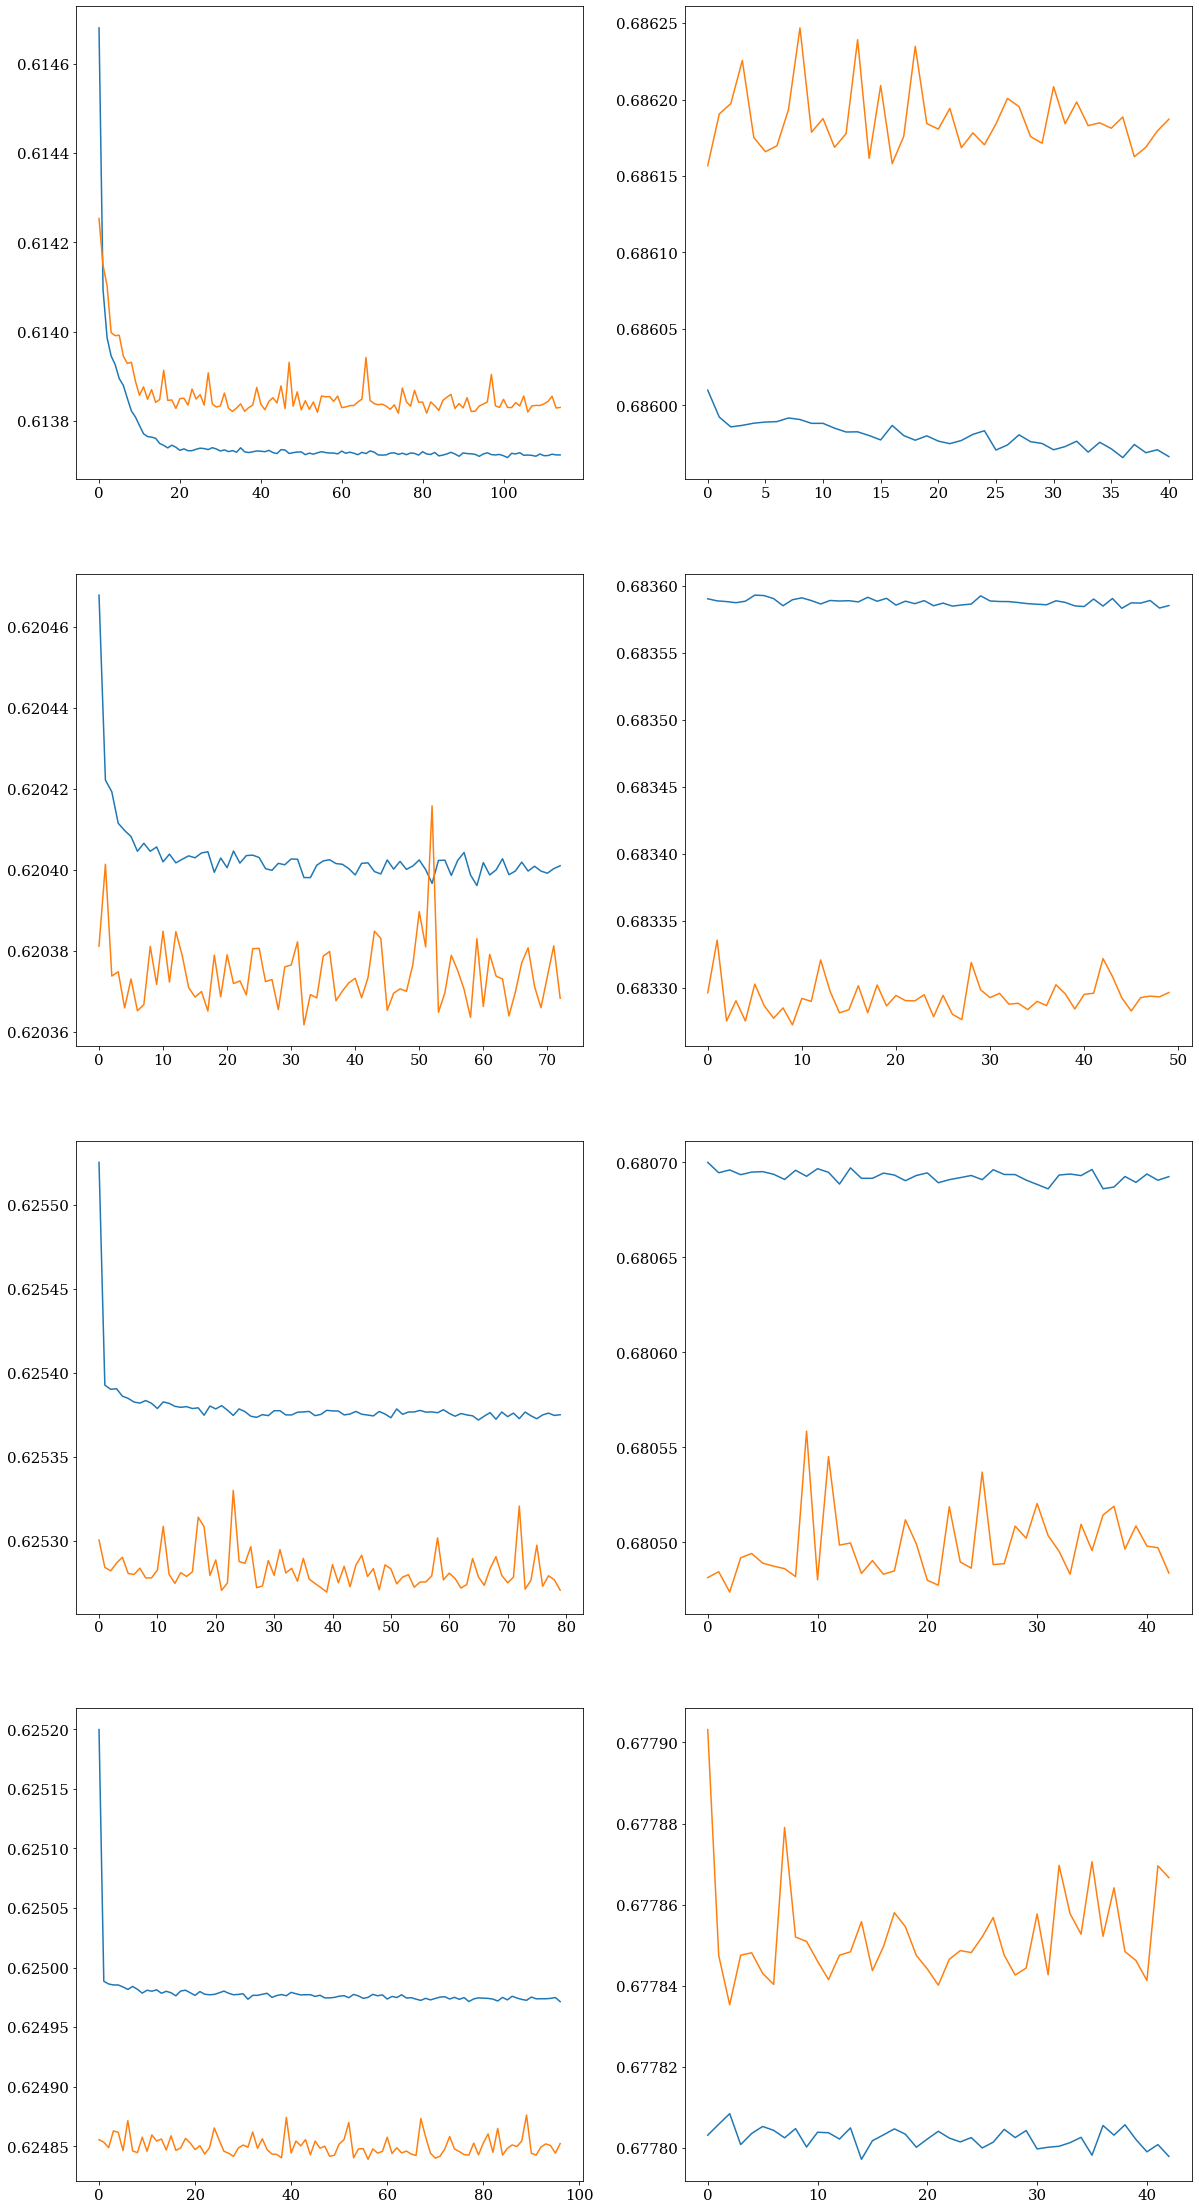

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()